In [0]:
import numpy as np

In [0]:
#def np_bin(x):
#  res = np.binary_repr(x, width=8)
#  return np.array(list(res), dtype=int)

def bin_to_str(x):
  return ''.join(map(str, x.reshape(-1)))

# d2b = np.unpackbits(np.arange(256, dtype=np.uint8).reshape(-1, 1), axis=1)
d2b = np.flip(np.unpackbits(np.arange(256, dtype=np.uint8).reshape(-1, 1), axis=1), 1)

In [0]:
def derivative(f, *args):
    return f(*args, derivative=True)

def sigmoid(x, derivative=False):
    if derivative:
        return x * (1. - x)
    return 1. / (1 + np.exp(-x))

def mse(y_pred, y_true, derivative=False):
    if derivative:
        return y_pred - y_true
    return np.sum((y_pred - y_true) ** 2) / 2

In [0]:
class BPTT:
  def __init__(self, in_dim, h_dim, out_dim, loss=mse):
    def init_weights(dim):
      return np.random.uniform(-1, 1, dim)

    self.loss = loss
    self.h0 = h0 = np.zeros((h_dim, 1))
    # trainable weights
    self.U = init_weights((h_dim, in_dim))
    self.W = init_weights((h_dim, h_dim))
    self.b = np.zeros((h_dim, 1))
    self.V = init_weights((out_dim, h_dim))
    self.c = np.zeros((out_dim, 1))

  def predict(self, X):
    assert(X.shape[-1] == 1), 'X should be a column vector'

    self.X, self.H, self.Y = X, [self.h0], []
    for x in X:
      ht = np.tanh(self.b + self.W @ self.H[-1] + self.U @ x)
      yt = sigmoid(self.c + self.V @ ht)
      self.H.append(ht)
      self.Y.append(yt)
    self.Y = np.array(self.Y)
    return np.where(self.Y >= 0.5, 1, 0)

  def update(self, Y_true, lr):
    assert(Y_true.shape[-1] == 1), 'Y should be a column vector'

    # \dv{L}{o^(t)}
    dLdot = derivative(self.loss, self.Y, Y_true) * derivative(sigmoid, self.Y)
    # H^(t) = \pdv{h^(t)}{a^(t)}
    Ht = [np.diag(1 - h.reshape(-1) ** 2) for h in self.H[1:]]
    # \dv{L}{h^(t)}
    T = Y_true.shape[0]
    dLdht = [None] * T
    dLdht[-1] = self.V.T @ dLdot[-1]
    for t in reversed(range(0, T - 1)):
      dLdht[t] = self.W.T @ Ht[t + 1] @ dLdht[t + 1] + self.V.T @ dLdot[t]
    # \dv{L}{a^(t)}
    dLdat = [Ht_t @ dLdht_t for Ht_t, dLdht_t in zip(Ht, dLdht)]

    # gradients
    dLdc = np.sum(dLdot, axis=0)
    dLdV = np.sum([dLdot_t * h_t.T for dLdot_t, h_t in zip(dLdot, self.H[1:])], axis=0)
    dLdb = np.sum(dLdat, axis=0)
    dLdW = np.sum([dLdat_t * h_t.T for dLdat_t, h_t in zip(dLdat, self.H[:-1])], axis=0)
    dLdU = np.sum([dLdat_t * x_t.T for dLdat_t, x_t in zip(dLdat, self.X)], axis=0)

    # update weights
    self.U -= lr * dLdU
    self.W -= lr * dLdW
    self.b -= lr * dLdb
    self.V -= lr * dLdV
    self.c -= lr * dLdc

    return self.loss(self.Y, Y_true)

In [5]:
in_dim, h_dim, out_dim = 2, 16, 1
net = BPTT(in_dim, h_dim, out_dim)
lr = 0.1
verbose = False

total_acc = []
for epoch in range(10001):
  (x0,), (x1,) = np.random.randint(0, 128, size=(in_dim, 1))
  X = np.array(list(zip(d2b[x0], d2b[x1]))).reshape(-1, in_dim, 1)
  Y = d2b[x0 + x1].reshape(-1, out_dim, 1)
  Y_pred = net.predict(X)
  loss = net.update(Y, lr)
  acc = int(np.all(Y_pred == Y))
  total_acc.append(acc)
  if epoch % 1000 == 0:
    acc = np.mean(total_acc[-1000:])
    print(f'[{epoch:5d}] loss: {loss:.2f}; avg acc: {acc:.2%}')
  if verbose:
    print('')
    print(f'  {x0:3d}', bin_to_str(d2b[x0]))
    print(f'+ {x1:3d}', bin_to_str(d2b[x1]))
    print('=' * 5, '-' * 8)
    print(f'  {x0 + x1:3d}', bin_to_str(d2b[x0 + x1]))
    print('Ypred', bin_to_str(Y_pred))
    print('-' * 20)

[    0] loss: 1.40; avg acc: 0.00%
[ 1000] loss: 0.73; avg acc: 7.80%
[ 2000] loss: 0.03; avg acc: 37.90%
[ 3000] loss: 0.01; avg acc: 78.20%
[ 4000] loss: 0.00; avg acc: 100.00%
[ 5000] loss: 0.01; avg acc: 100.00%
[ 6000] loss: 0.00; avg acc: 100.00%
[ 7000] loss: 0.00; avg acc: 100.00%
[ 8000] loss: 0.00; avg acc: 100.00%
[ 9000] loss: 0.00; avg acc: 100.00%
[10000] loss: 0.00; avg acc: 100.00%


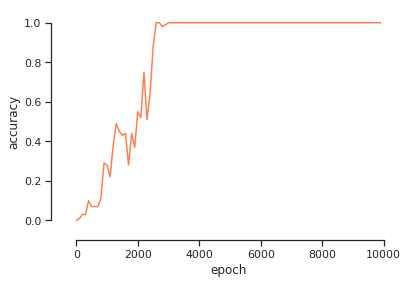

In [6]:
import pandas as pd
import seaborn as sns
sns.set(style='ticks')

X = list(range(0, 10001 - 100, 100))
Y = [np.mean(total_acc[x:x+100]) for x in X]
ax = sns.lineplot(x="epoch", y="accuracy", color='coral',
             data=pd.DataFrame(data={'epoch': X, 'accuracy': Y}))
sns.despine(offset=10, trim=True);